### Student Information
Name: 謝弘廷

Student ID: 110704054

GitHub ID: Kevindic0214

Kaggle name: Kevindic0214

Kaggle private scoreboard 

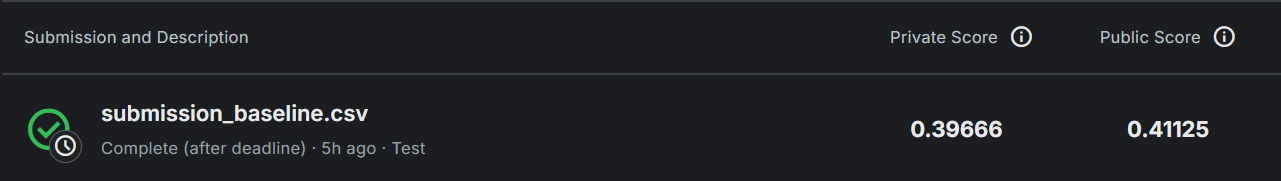

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

In [1]:
### Begin Assignment Here

匯入套件與讀取資料

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE  # 用於處理類別不平衡
import warnings

# 忽略警告訊息
warnings.filterwarnings('ignore')

# 如果是第一次使用nltk，需要下載相關資源
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# 1. 載入資料檔案
df_id = pd.read_csv('./data/data_identification.csv')
df_emotion = pd.read_csv('./data/emotion.csv')

tweets_data = []
with open('./data/tweets_DM.json', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line:
            data = json.loads(line)  # 將該行的JSON字串轉為Python字典
            # 根據您的JSON結構，擷取 tweet_id 與 text
            tweet_id = data['_source']['tweet']['tweet_id']
            text = data['_source']['tweet']['text']
            tweets_data.append((tweet_id, text))

# 將tweets_data轉為DataFrame
df_tweets = pd.DataFrame(tweets_data, columns=['tweet_id', 'text'])

# 將情緒標籤與資料集分別連接起來
df = df_id.merge(df_tweets, on='tweet_id', how='left')
df = df.merge(df_emotion, on='tweet_id', how='left')

# 顯示資料集的前幾筆資料
print(df.head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


   tweet_id identification                                               text  \
0  0x28cc61           test  @Habbo I've seen two separate colours of the e...   
1  0x29e452          train  Huge Respect🖒 @JohnnyVegasReal talking about l...   
2  0x2b3819          train  Yoooo we hit all our monthly goals with the ne...   
3  0x2db41f           test  @FoxNews @KellyannePolls No serious self respe...   
4  0x2a2acc          train  @KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...   

  emotion  
0     NaN  
1     joy  
2     joy  
3     NaN  
4   trust  


資料初探 (EDA)

資料筆數: 1867535
欄位資訊:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867535 entries, 0 to 1867534
Data columns (total 4 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tweet_id        object
 1   identification  object
 2   text            object
 3   emotion         object
dtypes: object(4)
memory usage: 57.0+ MB
None
缺失值統計:
tweet_id               0
identification         0
text                   0
emotion           411972
dtype: int64
Train / Test 分佈:
identification
train    1455563
test      411972
Name: count, dtype: int64
訓練集筆數: 1455563
測試集筆數: 411972
情緒分佈:
emotion
joy             516017
anticipation    248935
trust           205478
sadness         193437
disgust         139101
fear             63999
surprise         48729
anger            39867
Name: count, dtype: int64


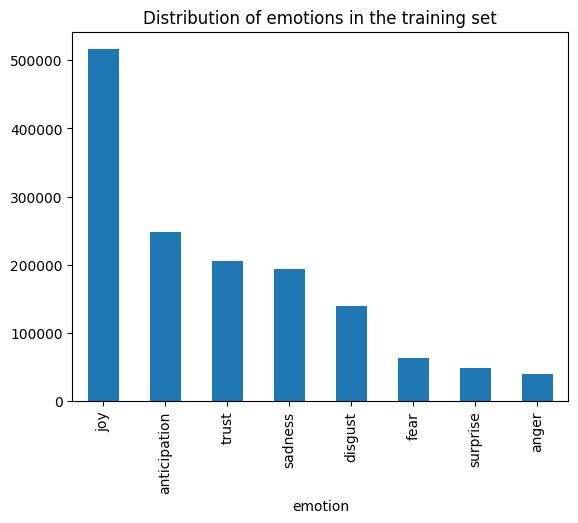

範例推文:
Tweet 0 (joy): Huge Respect🖒 @JohnnyVegasReal talking about losing his dad to cancer."if you dont remember the good times it was all for nothing"#beautiful
Tweet 1 (joy): Yoooo we hit all our monthly goals with the new app in two weeks. #spateradio #app <LH>
Tweet 2 (trust): @KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well done team 🌟 <LH> of every one of you.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 檢視基本資訊
print("資料筆數:", len(df))
print("欄位資訊:")
print(df.info())

# 檢查缺失值
print("缺失值統計:")
print(df.isnull().sum())

# 訓練集與測試集數量
print("Train / Test 分佈:")
print(df['identification'].value_counts())

# 僅限於有 emotion 的列（即 train 資料集）
train_df = df[df['identification'] == 'train'].dropna(subset=['emotion'])
print("訓練集筆數:", len(train_df))
print("測試集筆數:", len(df[df['identification'] == 'test']))

# 查看情緒分佈
print("情緒分佈:")
print(train_df['emotion'].value_counts())

# 將情緒分佈視覺化
plt.figure()
train_df['emotion'].value_counts().plot(kind='bar')
plt.title("Distribution of emotions in the training set")
plt.show()

# 檢視部分原始文字
print("範例推文:")
for i in range(3):
    print(f"Tweet {i} ({train_df.iloc[i]['emotion']}): {train_df.iloc[i]['text']}")


文本清理 (Preprocessing)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))  # 英文停用字

def clean_text(text):
    # 將文字轉為小寫
    text = text.lower()
    
    # 移除網址
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # 移除 @username
    text = re.sub(r'@\w+', '', text)
    
    # 移除標點符號、數字與特殊字元(只保留英文字母與空白)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 壓縮多個空白為一個空白
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 移除停用字 (可選)
    words = word_tokenize(text)
    filtered_words = [w for w in words if w not in stop_words]
    text = ' '.join(filtered_words)
    
    return text

# 對整個資料集進行清理
df['clean_text'] = df['text'].apply(clean_text)

# 檢視清理後結果
df[['tweet_id', 'text', 'clean_text', 'emotion', 'identification']].head()


,tweet_id,text,clean_text,emotion
0,0x28cc61,@Habbo I've seen two separate colours of the e...,ive seen two separate colours elegant furni ho...,NaN
1,0x29e452,Huge Respect🖒 @JohnnyVegasReal talking about l...,huge respect talking losing dad cancerif dont ...,joy
2,0x2b3819,Yoooo we hit all our monthly goals with the ne...,yoooo hit monthly goals new app two weeks spat...,joy
3,0x2db41f,@FoxNews @KellyannePolls No serious self respe...,serious self respecting individual believes mu...,NaN
4,0x2a2acc,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...,well done team lh every one,trust


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

# 分割訓練集與測試集
train_df = df[df['identification'] == 'train'].dropna(subset=['emotion'])
test_df = df[df['identification'] == 'test']

# 取得訓練資料與標籤
X_train_texts = train_df['clean_text'].values
y_train = train_df['emotion'].values

# 取得測試資料
X_test_texts = test_df['clean_text'].values

# 將資料再分為訓練集與驗證集 (以便檢查模型成效)
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train_texts, y_train, test_size=0.2, random_state=42, stratify=y_train)

# 使用 TF-IDF 將文字轉為向量
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),     # 可調整 n-gram 範圍
    max_features=10000,    # 可根據需要調整特徵數量上限
    stop_words='english'   # 英文停用字移除 (若已事先移除可不加)
)

vectorizer.fit(X_train_part)
X_train_part_vec = vectorizer.transform(X_train_part)
X_val_vec = vectorizer.transform(X_val)

# 訓練基準模型 (Logistic Regression)
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_part_vec, y_train_part)

# 在驗證集上預測
y_val_pred = model.predict(X_val_vec)

# 評估模型
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))
print("F1-Score:", f1_score(y_val, y_val_pred, average='weighted'))

# 使用整個訓練集 (train_df) 再訓練一次最終模型
# 在最終提交前，我們使用所有的 train 資料以取得最佳模型表現
X_train_full_vec = vectorizer.fit_transform(X_train_texts)
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_full_vec, y_train)

# 對測試集進行預測
X_test_vec = vectorizer.transform(X_test_texts)
y_test_pred = model.predict(X_test_vec)

# 生成提交檔案
# Kaggle 比賽規定的提交格式是： id, emotion
submission = test_df[['tweet_id']].copy()
submission['emotion'] = y_test_pred
submission.to_csv('submission_baseline.csv', index=False)
print("Submission file 'submission_baseline.csv' generated!")

Validation Classification Report:
              precision    recall  f1-score   support

       anger       0.58      0.19      0.28      7973
anticipation       0.60      0.52      0.56     49787
     disgust       0.44      0.34      0.38     27820
        fear       0.65      0.33      0.44     12800
         joy       0.53      0.80      0.63    103204
     sadness       0.45      0.42      0.43     38687
    surprise       0.58      0.17      0.26      9746
       trust       0.54      0.28      0.36     41096

    accuracy                           0.53    291113
   macro avg       0.54      0.38      0.42    291113
weighted avg       0.53      0.53      0.50    291113

F1-Score: 0.5017406337013288
Submission file 'submission_baseline.csv' generated!
